In [ ]:
!pip install fairseq

In [ ]:
import torch
import torchaudio
import soundfile as sf
import numpy as np
import fairseq

In [ ]:
import os
def get_speaker_gender(txt_file, directory):
    speaker_data = {}
    female_speakers = []
    male_speakers = []

    # Read the TXT file
    with open(txt_file, 'r') as file:
        lines = file.readlines()

    # Parse the data
    for line in lines:
        if line.startswith(';'):
            continue
        speaker_id, gender, subset, *_ = line.strip().split('|')
        if subset.strip() == 'dev-clean':
            speaker_data[speaker_id.strip()] = 1 if gender.strip() == 'M' else 0

    # Get speaker ids from directory
    for speaker_id in speaker_data.keys():
        speaker_dir = os.path.join(directory, speaker_id)
        if os.path.exists(speaker_dir):
            # print(speaker_dir)
            if speaker_data[speaker_id] == 0:
                female_speakers.append(speaker_id)
            elif speaker_data[speaker_id] == 1:
                male_speakers.append(speaker_id)

    return speaker_data, female_speakers, male_speakers

txt_file_path = "/content/drive/MyDrive/dev-clean/LibriSpeech/SPEAKERS.TXT"
directory_path = "/content/drive/MyDrive/dev-clean/LibriSpeech/dev-clean/"
speaker_data, female_speakers, male_speakers = get_speaker_gender(txt_file_path, directory_path)
print(speaker_data, female_speakers, male_speakers)

{'84': 0, '174': 1, '251': 1, '422': 1, '652': 1, '777': 1, '1272': 1, '1462': 0, '1673': 0, '1919': 0, '1988': 0, '1993': 0, '2035': 0, '2078': 1, '2086': 1, '2277': 0, '2412': 0, '2428': 1, '2803': 1, '2902': 1, '3000': 1, '3081': 0, '3170': 1, '3536': 0, '3576': 0, '3752': 1, '3853': 0, '5338': 0, '5536': 1, '5694': 1, '5895': 0, '6241': 1, '6295': 1, '6313': 0, '6319': 0, '6345': 0, '7850': 0, '7976': 1, '8297': 1, '8842': 0} ['84', '1462', '1673', '1919', '1988', '1993', '2035', '2277', '2412', '3081', '3536', '3576', '3853', '5338', '5895', '6313', '6319', '6345', '7850', '8842'] ['174', '251', '422', '652', '777', '1272', '2078', '2086', '2428', '2803', '2902', '3000', '3170', '3752', '5536', '5694', '6241', '6295', '7976', '8297']


In [ ]:
import random

def split_data_equal(male_speakers, female_speakers, percentage):

    # Shuffle male and female speaker IDs separately to ensure randomness
    random.shuffle(male_speakers)
    random.shuffle(female_speakers)

    # Determine the split index based on the given percentage
    split_index = int(min(len(male_speakers), len(female_speakers)) * percentage)

    # Split male and female speaker IDs into training and testing sets
    male_train = male_speakers[:split_index]
    male_test = male_speakers[split_index:]

    female_train = female_speakers[:split_index]
    female_test = female_speakers[split_index:]

    return male_train, female_train, male_test, female_test

percentage = 0.8  # 80% for training, 20% for testing
male_train, female_train, male_test, female_test = split_data_equal(male_speakers, female_speakers, percentage)
print("Male IDs for training:", male_train)
print("Female IDs for training:", female_train)
print("Male IDs for testing:", male_test)
print("Female IDs for testing:", female_test)

Male IDs for training: ['1272', '777', '6295', '7976', '2078', '2902', '2803', '3752', '5694', '2428', '5536', '3000', '652', '3170', '6241', '2086']
Female IDs for training: ['5895', '6319', '2035', '3853', '1462', '7850', '6313', '1988', '3081', '8842', '3576', '6345', '2277', '84', '1919', '5338']
Male IDs for testing: ['251', '174', '8297', '422']
Female IDs for testing: ['1993', '2412', '1673', '3536']


In [ ]:
wav2vec2_checkpoint_path = "/content/drive/MyDrive/wav2vec_small.pt"
checkpoint = torch.load(wav2vec2_checkpoint_path)
cfg = fairseq.dataclass.utils.convert_namespace_to_omegaconf(checkpoint['args'])
wav2vec2_encoder = fairseq.models.wav2vec.Wav2Vec2Model.build_model(cfg.model)

wav2vec2_encoder.load_state_dict(checkpoint['model'])
audio = torch.randn(1,10000)
features = wav2vec2_encoder(audio, features_only=True, mask=False)['x']

In [ ]:
# Load the .flac audio file
# audio_file = "/content/drive/MyDrive/dev-clean/LibriSpeech/dev-clean/84/121123/84-121123-0002.flac"

def extract_features(audio_file, speaker_id):
    waveform, sample_rate = torchaudio.load(audio_file)

    # Calculate the number of samples in a 2-second chunk
    chunk_size = 2 * sample_rate

    # Split the audio into 2-second subsequent chunks
    chunks = []
    ids = []
    for i in range(0, waveform.shape[1], chunk_size):
        chunk = waveform[:, i:i+chunk_size]
        chunks.append(chunk)

    # Extract features for each chunk
    features = []

    for chunk in chunks:
        if waveform.shape[0] > 1:
            chunk = torch.mean(chunk, dim=0, keepdim=True)
        # Ensure the chunk has the right size
        if chunk.shape[1] < chunk_size:
            padding = torch.zeros(1, chunk_size - chunk.shape[1])
            chunk = torch.cat([chunk, padding], dim=1)
        # Extract features
        with torch.no_grad():
            z = wav2vec2_encoder(chunk, features_only=True, mask=False)['x'] #torch.Size([1, 99, 768])
            y = torch.mean(z, dim=1) #torch.Size([1, 1, 768])
            # feature = y.transpose(0, 1)
        # print(y.size())
        features.append(y)
        ids.append([int(speaker_id)])

    # print(np.array(features).shape)
    features_np = np.squeeze(features, axis=1)

    # print("Shape of extracted features:", features_np.shape)
    return features_np, np.array(ids)


In [45]:
def extract_all_embeddings(directory, speaker_ids):
    all_embeddings = np.empty((1, 768))
    ids = np.empty((0, 1))
    for speaker_id in speaker_ids:
        speaker_dir = os.path.join(directory, str(speaker_id))
        print("Extracting embeddings for speaker:{}".format(speaker_id))
        if not os.path.exists(speaker_dir):
            continue

        for root, dirs, files in os.walk(speaker_dir):
            for file in files:
                if file.endswith('.flac'):
                    audio_file = os.path.join(root, file)
                    features, id = extract_features(audio_file, speaker_id)
                    all_embeddings = np.concatenate((all_embeddings, features))
                    ids = np.concatenate((ids, id))

    return all_embeddings[1:], ids

directory = "/content/drive/MyDrive/dev-clean/LibriSpeech/dev-clean/"
male_embeddings_train, male_id_train = extract_all_embeddings(directory, male_train)
female_embeddings_train, female_id_train = extract_all_embeddings(directory, female_train)
male_embeddings_test, male_id_test = extract_all_embeddings(directory, male_test)
female_embeddings_test, female_id_test = extract_all_embeddings(directory, female_test)

Extracting embeddings for speaker:1272
Extracting embeddings for speaker:777
Extracting embeddings for speaker:6295
Extracting embeddings for speaker:7976
Extracting embeddings for speaker:2078
Extracting embeddings for speaker:2902
Extracting embeddings for speaker:2803
Extracting embeddings for speaker:3752
Extracting embeddings for speaker:5694
Extracting embeddings for speaker:2428
Extracting embeddings for speaker:5536
Extracting embeddings for speaker:3000
Extracting embeddings for speaker:652
Extracting embeddings for speaker:3170
Extracting embeddings for speaker:6241
Extracting embeddings for speaker:2086
Extracting embeddings for speaker:5895
Extracting embeddings for speaker:6319
Extracting embeddings for speaker:2035
Extracting embeddings for speaker:3853
Extracting embeddings for speaker:1462
Extracting embeddings for speaker:7850
Extracting embeddings for speaker:6313
Extracting embeddings for speaker:1988
Extracting embeddings for speaker:3081
Extracting embeddings for s

In [46]:
print(male_embeddings_train.shape)

(4438, 768)


In [77]:
np.savez('/content/drive/MyDrive/male_train', male_embeddings_train, male_id_train)
np.savez('/content/drive/MyDrive/female_train', female_embeddings_train, female_id_train)
np.savez('/content/drive/MyDrive/male_test', male_embeddings_test, male_id_test)
np.savez('/content/drive/MyDrive/female_test', female_embeddings_test, female_id_test)

train_dataset_ = np.concatenate((male_embeddings_train, female_embeddings_train), axis = 0)
train_dataset_id = np.concatenate((male_id_train, female_id_train), axis = 0)

test_dataset_ = np.concatenate((male_embeddings_test, female_embeddings_test), axis = 0)
test_dataset_id = np.concatenate((male_id_test, female_id_test), axis = 0)

embeddings = np.concatenate((train_dataset_, test_dataset_), axis = 0)
ids = np.concatenate((train_dataset_id, test_dataset_id), axis = 0)

np.save('/content/drive/MyDrive/embeddings', embeddings)
np.save('/content/drive/MyDrive/ids', ids)


In [78]:
print("Shape of male train embeddings array:", male_embeddings_train.shape, male_id_train.shape)
print("Shape of female train embeddings:", female_embeddings_train.shape, female_id_train.shape)
print("Shape of male test embeddings array:", male_embeddings_test.shape, male_id_test.shape)
print("Shape of female test embeddings array:", female_embeddings_test.shape, female_id_test.shape)

print("Shape of train embeddings array:", embeddings.shape, ids.shape)


Shape of male train embeddings array: (4438, 768) (4438, 1)
Shape of female train embeddings: (4466, 768) (4466, 1)
Shape of male test embeddings array: (1101, 768) (1101, 1)
Shape of female test embeddings array: (1080, 768) (1080, 1)
Shape of train embeddings array: (11085, 768) (11085, 1)


In [80]:
embeddings = np.load('/content/drive/MyDrive/embeddings.npy')
ids = np.load('/content/drive/MyDrive/ids.npy')

print(embeddings.shape, ids.shape)

(11085, 768) (11085, 1)


In [82]:
import numpy as np

def train_test_split(embeddings, ids, test_percentage=0.2):
    """
    Shuffles the embeddings and their corresponding IDs randomly
    and splits them into train and test arrays based on the given percentage.

    Args:
    - embeddings (np.ndarray): Array of embeddings with shape (num_samples, embedding_dim).
    - ids (np.ndarray): Array of corresponding IDs with shape (num_samples, 1).
    - test_percentage (float): Percentage of samples to be allocated for testing.

    Returns:
    - train_embeddings (np.ndarray): Train embeddings array.
    - train_ids (np.ndarray): Train IDs array.
    - test_embeddings (np.ndarray): Test embeddings array.
    - test_ids (np.ndarray): Test IDs array.
    """
    # Shuffle the indices
    num_samples = embeddings.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    # number of samples for testing
    num_test_samples = int(test_percentage * num_samples)

    # Split the indices into train and test sets
    test_indices = indices[:num_test_samples]
    train_indices = indices[num_test_samples:]

    # Split the embeddings and IDs arrays based on the selected indices
    train_embeddings = embeddings[train_indices]
    train_ids = ids[train_indices]
    test_embeddings = embeddings[test_indices]
    test_ids = ids[test_indices]

    return train_embeddings, train_ids, test_embeddings, test_ids

train_embeddings, train_ids, test_embeddings, test_ids = train_test_split(embeddings, ids, test_percentage=0.2)
print(train_embeddings.shape, train_ids.shape)
print(test_embeddings.shape, test_ids.shape)



(8868, 768) (8868, 1)
(2217, 768) (2217, 1)


In [98]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# print(train_dataset.shape, train_dataset_id.shape)
# print(test_dataset.shape, test_dataset_id.shape)
clf = GaussianNB()
clf.fit(train_embeddings, train_ids)
y_train_pred = clf.predict(train_embeddings)
print(y_train_pred)
print(classification_report(train_ids, y_train_pred))
y_test_pred = clf.predict(test_embeddings)
print(classification_report(test_ids, y_test_pred))

[2035. 3000.  422. ... 3000. 3576. 3000.]
              precision    recall  f1-score   support

        84.0       0.39      0.20      0.26       224
       174.0       0.15      0.27      0.19       230
       251.0       0.54      0.03      0.06       221
       422.0       0.14      0.83      0.24       225
       652.0       0.46      0.42      0.44       222
       777.0       0.65      0.05      0.09       234
      1272.0       0.95      0.09      0.16       220
      1462.0       0.19      0.18      0.18       241
      1673.0       0.15      0.78      0.25       209
      1919.0       0.78      0.50      0.61       224
      1988.0       0.83      0.13      0.23       221
      1993.0       0.82      0.15      0.26       216
      2035.0       0.46      0.20      0.28       228
      2078.0       0.60      0.11      0.18       199
      2086.0       0.83      0.11      0.20       217
      2277.0       0.10      0.32      0.15       234
      2412.0       0.90      0.09      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
from sklearn.svm import SVC

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the SVM model
svm_classifier.fit(train_embeddings, train_ids)

# Predict using the SVM model
y_train_pred = svm_classifier.predict(train_embeddings)
y_test_pred = svm_classifier.predict(test_embeddings)

print(classification_report(train_ids, y_train_pred))
print(classification_report(test_ids, y_test_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

        84.0       0.98      1.00      0.99       224
       174.0       0.97      0.99      0.98       230
       251.0       0.99      1.00      0.99       221
       422.0       1.00      0.99      1.00       225
       652.0       0.99      1.00      0.99       222
       777.0       0.99      1.00      0.99       234
      1272.0       1.00      1.00      1.00       220
      1462.0       0.99      0.98      0.99       241
      1673.0       1.00      0.98      0.99       209
      1919.0       0.97      1.00      0.98       224
      1988.0       1.00      0.98      0.99       221
      1993.0       1.00      1.00      1.00       216
      2035.0       1.00      0.99      0.99       228
      2078.0       0.99      0.97      0.98       199
      2086.0       1.00      1.00      1.00       217
      2277.0       1.00      1.00      1.00       234
      2412.0       0.99      1.00      0.99       199
      2428.0       0.97    

In [85]:
from sklearn.neural_network import MLPClassifier

# Create an MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 20, 2),
                        max_iter = 300,activation = 'relu',
                        solver = 'adam')
# Train the model
mlp_clf.fit(train_embeddings, train_ids)

# Predict using the MLP model
accuracy = mlp_clf.score(test_embeddings, test_ids)
print(classification_report(train_ids, y_train_pred))
print(classification_report(test_ids, y_test_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

        84.0       0.98      1.00      0.99       224
       174.0       0.97      0.99      0.98       230
       251.0       0.99      1.00      0.99       221
       422.0       1.00      0.99      1.00       225
       652.0       0.99      1.00      0.99       222
       777.0       0.99      1.00      0.99       234
      1272.0       1.00      1.00      1.00       220
      1462.0       0.99      0.98      0.99       241
      1673.0       1.00      0.98      0.99       209
      1919.0       0.97      1.00      0.98       224
      1988.0       1.00      0.98      0.99       221
      1993.0       1.00      1.00      1.00       216
      2035.0       1.00      0.99      0.99       228
      2078.0       0.99      0.97      0.98       199
      2086.0       1.00      1.00      1.00       217
      2277.0       1.00      1.00      1.00       234
      2412.0       0.99      1.00      0.99       199
      2428.0       0.97    

In [ ]:
!pip install --user tensorflow
!pip install --user keras

In [91]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

In [ ]:
train_ids = train_ids.ravel()
test_ids = test_ids.ravel()

# Map the speaker IDs to integer values
unique_ids = np.unique(ids)
id_mapping = {id_: i for i, id_ in enumerate(unique_ids)}
train_mapped_ids = np.array([[id_mapping[id_]] for id_ in train_ids])
test_mapped_ids = np.array([[id_mapping[id_]] for id_ in train_ids])

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the mapped IDs
train_one_hot_encoded = encoder.fit_transform(train_mapped_ids)
test_one_hot_encoded = encoder.fit_transform(test_mapped_ids)

# print("One-hot encoded vector:")
# print(test_mapped_ids[:10])
# print(test_one_hot_encoded[:10])

In [97]:
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D

X_train = train_embeddings
X_test = test_embeddings
Y_train = train_one_hot_encoded
Y_test = test_one_hot_encoded

input_shape = (X_train.shape[1], 1)
model = Sequential()
model.add(Conv1D(512, 3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(256, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(unique_ids), activation='softmax'))

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=40, batch_size=10)

Epoch 1/40
710/710 [==============================] - 286s 397ms/step - loss: 3.6893 - accuracy: 0.0266 - val_loss: 3.6767 - val_accuracy: 0.0547
Epoch 2/40
710/710 [==============================] - 282s 398ms/step - loss: 3.4982 - accuracy: 0.0798 - val_loss: 3.0151 - val_accuracy: 0.2086
Epoch 3/40
710/710 [==============================] - 282s 397ms/step - loss: 3.1272 - accuracy: 0.1455 - val_loss: 2.6635 - val_accuracy: 0.3439
Epoch 4/40
710/710 [==============================] - 278s 390ms/step - loss: 2.9435 - accuracy: 0.1741 - val_loss: 2.4548 - val_accuracy: 0.4064
Epoch 5/40
710/710 [==============================] - 265s 374ms/step - loss: 2.8119 - accuracy: 0.2050 - val_loss: 2.2205 - val_accuracy: 0.4729
Epoch 6/40
710/710 [==============================] - 266s 374ms/step - loss: 2.7301 - accuracy: 0.2176 - val_loss: 2.1152 - val_accuracy: 0.5107
Epoch 7/40
710/710 [==============================] - 259s 364ms/step - loss: 2.6826 - accuracy: 0.2365 - val_loss: 2.0924 -

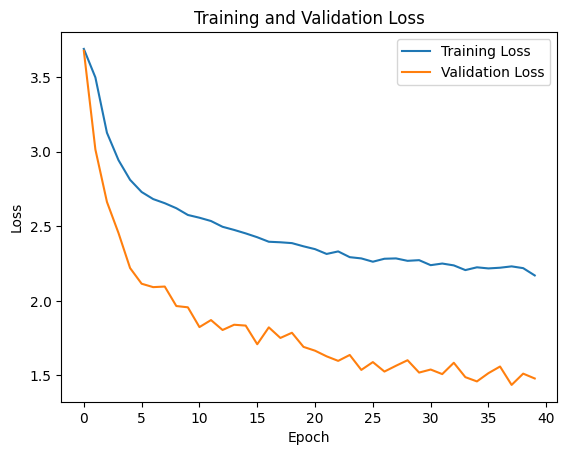

In [99]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()